# Train transformer encoder 

The input of the sequence classifier is a timeseries of a high dimension vector.

Train a encoder transformer from scratch, on sequence classification. Similar to BERT paper, we add a [CLS] token to the sequence start.
Then we learn an embedding on the 10-dimensional feature vector, add positional encoding, and run the data through an encoder stack.
We add a small feed-forward neural network to the final [CLS] token representation, plus a softmax for class prediction.

More resources:
- [TensorFlow tutorial](https://www.tensorflow.org/text/tutorials/transformer) for Transformer encoder/decoder
- [BERT paper](https://arxiv.org/abs/1810.04805) with the detailed description of the encoder stack

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from transformer_classifier import TransformerEncoder

In [35]:
# All hyper parameters

# The preprocessed datset is ready here:
DATASET = "dataset_career_con_2019.npz"
EPOCHS = 30
# Each timestep is represented by this internal token dimension
D_MODEL = 4
# The number of attention heads we learn
ATTENTION_HEADS = 8
# The encoder stack size
NUM_ENCODERS = 4
BATCH_SIZE = 16
SEQUENCE_LENGTH = 128
# The length of positional encoding, after which the encoding repeats itself
POSITIONAL_ENCODING_PERIOD = 2 * SEQUENCE_LENGTH
# The learning rate for training
LR = 0.002
# Dropout throughout the transformer (in attention heads, after feed forward neural
#   network, in classification head, and after token embedding)
DROPOUT = 0.1
# L2 regularization for classification head
REGULARIZATION = 0.01
# Dimension of the learned keys in the self-attention layers
KEY_DIM = D_MODEL
# The token dimension in the feed forward neural network. The input and output have dimension "D_MODEL",
# but inside the feed forward neural network, between the two dense layers, we use dimension "DIM_FF"
DIM_FF = 4 * D_MODEL
# The fix [CLS] token that we add to the start of each sequence
CLS = -1

## Load dataset

In [36]:
def load_dataset_split(dataset):
    """
    Load training and test data.
    """
    load_dataset = np.load(dataset, allow_pickle=True)
    x_train = load_dataset['x_train']
    y_train = load_dataset['y_train']
    x_test = load_dataset['x_test']
    y_test = load_dataset['y_test']
    return (x_train,y_train,x_test,y_test)

In [37]:
def add_cls_token(x):
    """
    Add a [CLS] token to each sequence
    """
    cls_event = np.repeat(CLS, repeats = x.shape[2]).reshape(1,-1)
    x = np.insert(x, 0, cls_event, axis=1)
    return x

In [38]:
# load dataset from NPZ file
x_train,y_train,x_test,y_test = load_dataset_split(DATASET)

# add CLS starter token to all sequences
x_train = add_cls_token(x_train)
x_test = add_cls_token(x_test)

## Perform the training

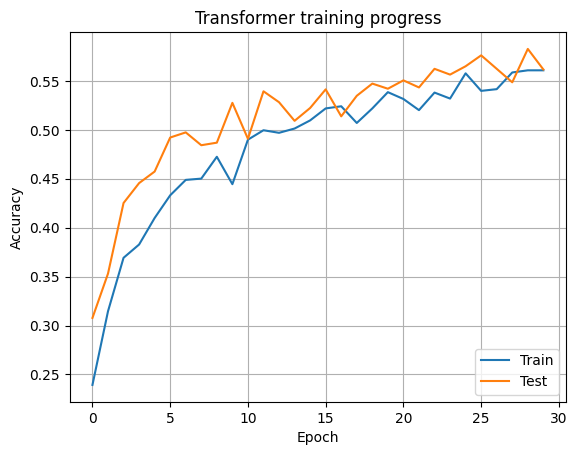

In [39]:
transformer = TransformerEncoder(
    num_layers = NUM_ENCODERS,
    d_model = D_MODEL,
    num_heads = ATTENTION_HEADS,
    key_dim = KEY_DIM,
    dff = DIM_FF,
    dropout_rate = DROPOUT,
    positional_encoding_period = POSITIONAL_ENCODING_PERIOD,
    regularization = REGULARIZATION,
    num_classes = y_train.shape[1])
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
transformer.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy'])
history = transformer.fit(x_train, y_train, epochs = EPOCHS,
                          validation_data = (x_test, y_test),
                          batch_size = BATCH_SIZE,
                          verbose = 0)

# draw training progress
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Transformer training progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid(visible=True)
plt.show()